![](../img/330-banner.png)

<br><br><br>
<img src="https://media.licdn.com/dms/image/C5622AQG0zUZ7YBpKMA/feedshare-shrink_800/0/1677468692008?e=1680739200&v=beta&t=s3RUU4qy0ky0D5b4y02bL9J2g2eeD4fQ1USrClhXB5I">
<br><br><br>

# Lecture 11: Ensembles
--------------

UBC 2022-23 W2

Instructor: Amir Abdi
 - Office Hours: Mondays 5-6 (or 5-7 if student turn-out was high)
 

<br><br><br><br><br><br>

## Legends

    
| <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/This_is_the_photo_of_Arthur_Samuel.jpg" width="100"> | <img src="http://www.cs.cmu.edu/~tom/TomHead2-6-22-22.jpg" width="100">  | <img src="https://upload.wikimedia.org/wikipedia/commons/4/49/John_McCarthy_Stanford.jpg" width="100"> | <img src="https://datascience.columbia.edu/wp-content/uploads/2020/08/Vapnik_web.png" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/a/a1/Alan_Turing_Aged_16.jpg" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/Yoshua_Bengio_2019_cropped.jpg" width="100"> |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | 
| Arthur Samuel       | Tom Mitchell       |John McCarthy|  Vladimir N. Vapnik | Alan Turing | Yoshua Bengio |
| (1901-1990)    | 1951 - Now       |  1927 – 2011 | 1936 - Now | 1912 – 1954 | 1964-Now |
| First computer learning program | 1997 ML Texbook, CMU Prof | Co-coined term AI, Lisp,<br> Time-sharing, Garbage collection | SVM | Turing Test, Turning Machine | Turing Award<br> Father of Deep Learning


## Imports, announcements, LOs 

### Imports

In [2]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../code/.")

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

### Announcements

- How was the midterm
- HW5 due hw5 March 1, 11:59pm

### Lecture learning objectives

From this lecture, you will be able to 

- Use `scikit-learn`'s `RandomForestClassifier` and explain its main hyperparameters. 
- Explain randomness in random forest algorithm. 
- Use other tree-based models such as as `XGBoost` and `LGBM`.  
- Employ ensemble classifier approaches, in particular model averaging and stacking.
- Explain voting and stacking and the differences between them.
- Use `scikit-learn` implementations of these ensemble methods.

## Motivation


- **Ensembles** are models that combine multiple machine learning models to create more powerful models.
- There are different strategies in Ensembling models:
  - Bagging
  - Boosting
  - Stacking

<br><br><br><br><br><br><br><br>

### The Netflix prize

![](../img/netflix.png)

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

- Most of the winning solutions for Kaggle competitions involve some kind of ensembling. For example: 


<img src="../img/fraud_detection_kaggle.png" width="600" height="600">


<br><br><br><br><br><br><br>
Key idea: **Group (ensemble) of Models** can make better decisions than **individual models**, especially when models are diverse enough. 


<br><br><br><br><br><br><br>

What's the cost? (why not always use ensembles?)

Answer: 
- Takes longer to run all the models (during prediction after deployment to production)
- More complex solution (e.g. much more hparams to tune, etc.)
- More compute and more time to train the model
- Maintenance challenges of the system as you need to maintain and keep updating 100s of models
- ...

<br><br><br><br><br><br><br>


### Tree-based ensemble models 

- We'll briefly talk about two such models: 
    - Random forests
    - Gradient boosted trees
- We'll also talk about averaging and stacking. 

### Tree-based models 

- Decision trees models are 
    - Interpretable 
    - They can capture **non-linear relationships**
    - They don't require scaling of the data
    - Can work with categorical features. 

<img src="https://cdck-file-uploads-global.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/2X/7/72d79a7b7841d04a077c5ac7a01590c341d9a041.png">

[image source](https://discuss.analyticsvidhya.com/t/how-decision-tree-performs-non-linear-classification/6001)

### Data

Let's work with [the adult census data set from kaggle](https://www.kaggle.com/uciml/adult-census-income). 

Predicting **income** as a binary classification problem (**above 50k** or **below 50k** income)

In [3]:
adult_df_large = pd.read_csv("../data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.6, random_state=42)

# Replace question marks in the dataset with NaN values
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
2729,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K
6850,40,NaN,78255,HS-grad,9,Divorced,NaN,Not-in-family,White,Male,0,0,25,United-States,<=50K
414,46,Private,102771,Masters,14,Married-civ-spouse,Tech-support,Husband,White,Male,0,1977,40,United-States,>50K
7887,33,Private,145434,11th,7,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
23438,28,Private,210945,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,35,Haiti,<=50K


In [4]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [5]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [6]:
assert set(education_levels) == set(train_df["education"].unique())

In [7]:
numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = make_pipeline(
    OrdinalEncoder(categories=[education_levels], dtype=int)
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

<br><br><br>
Create train and test sets.

In [9]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is *a bit of* class imbalance.
- Let's use **accuracy** as our metric. 

In [10]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.75906
>50K     0.24094
Name: income, dtype: float64

In [12]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [13]:
results = {}

<br><br><br><br><br>

-----------
[Study on your own]  
Main item to focus on: **what is stratified DummyClassifier?**


> “stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The predict method returns the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

### Baselines

####  `DummyClassifier` baseline

In [14]:
from utils import mean_std_cross_val_scores
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
results["Dummy"]

fit_time       0.005 (+/- 0.001)
score_time     0.003 (+/- 0.000)
test_score     0.633 (+/- 0.006)
train_score    0.634 (+/- 0.005)
dtype: object

[End of study on your own]

---------
<br><br><br><br><br>

#### `DecisionTreeClassifier` baseline

- Let's try decision tree classifier on our data. 

In [15]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.001),0.003 (+/- 0.000),0.633 (+/- 0.006),0.634 (+/- 0.005)
Decision tree,0.103 (+/- 0.009),0.014 (+/- 0.002),0.811 (+/- 0.002),1.000 (+/- 0.000)


Decision tree is clearly **OVERFITTIG**. 

<br><br><br><br>

## Random forests 

### General idea

- A single decision, without any constraints on the max-depth or number of leaves, tree is likely to overfit
- Use a collection of diverse decision trees
- Each tree *might overfit* on some part of the data but we can **reduce overfitting by AVERAGING or VOTING on the results** 

### `RandomForestClassifier` 

- Before understanding the details let's first try it out.  

In [17]:
from sklearn.ensemble import RandomForestClassifier

# ----- NEW CLASSIFIER: RandomForestClassifier -----
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1, n_estimators=100)
)
# --------------------------
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.001),0.003 (+/- 0.000),0.633 (+/- 0.006),0.634 (+/- 0.005)
Decision tree,0.103 (+/- 0.009),0.014 (+/- 0.002),0.811 (+/- 0.002),1.000 (+/- 0.000)
Random forests,1.929 (+/- 0.058),0.204 (+/- 0.002),0.854 (+/- 0.003),1.000 (+/- 0.000)


The validation scores are better although it seems likes we are still overfitting. 

### How do they work? 

- Decide **how many decision trees** we want to build
    - can control with `n_estimators` hyperparameter 
- `fit` a diverse set of that many decision trees by **injecting randomness** in the classifier construction
- `predict` by voting (classification) or averaging (regression) of predictions given by individual models

### Inject randomness in the classifier construction

To ensure that the trees in the random forest are different we inject randomness in two ways:  

1. **Data Bagging (Bootstrap Aggregation)**: Build each tree on a **random bootstrapped subset of samples** (i.e., a sample drawn **with replacement** from the training set)
2. **Feature Bagging**: At each node, select a **random subset of features** (controlled by `max_features` in `scikit-learn`) and look for the best possible test involving one of these features   

<br><br><br>

--------------

**Bootstrapping** is a statistical resampling technique that involves **random sampling** of a dataset **with replacement**. 
<br><br><br>

An example of a bootstrap samples
Suppose this is your original dataset: [1,2,3,4]
- a sample drawn with replacement: [1,1,3,4]
- a sample drawn with replacement: [3,2,2,2]
- a sample drawn with replacement: [1,2,4,4]
- ...

--------------

### The RandomForest classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sampling of the data.
- At each node:
    - At each node, **randomly and independently select a subset** of features out of all features
    - Find the best split on the selected features. 
    - Grow the trees to the specified `max_depth`.
- Prediction time    
    - Vote the trees to get predictions for new example. 

### Example 

- Let's create a random forest with **3 estimators** (3 trees). 
- I'm using `max_depth=2` for easy visualization. 

In [18]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train);

- Let's sample a test example. 

In [19]:
test_example = X_test.sample(1)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))


Classes:  ['<=50K' '>50K']
Prediction by random forest:  ['<=50K']


--------------
[Study on your own]  
**Check how the transformer is transforming the features** 

Let's get the feature names of transformed features.

In [21]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + list(
        pipe_rf_demo.named_steps["columntransformer"]
        .named_transformers_["pipeline-4"]
        .named_steps["onehotencoder"]
        .get_feature_names_out()
    )
)
feature_names[:10]

['age',
 'fnlwgt',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'x0_Federal-gov',
 'x0_Local-gov',
 'x0_Never-worked']

In [ ]:
transformed_example = preprocessor.transform(test_example)
pd.DataFrame(data=transformed_example.flatten(), index=feature_names)

[End of study on your own]

------------

- We can look at different trees created by random forest. 
- Note that each tree looks at different set of features and slightly different data. 



Tree 1


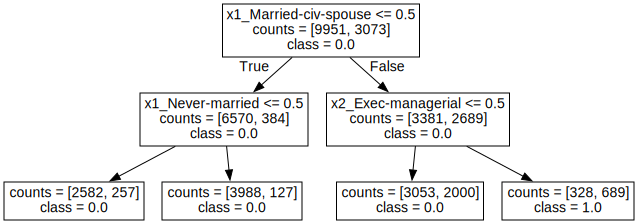

prediction [0.]


Tree 2


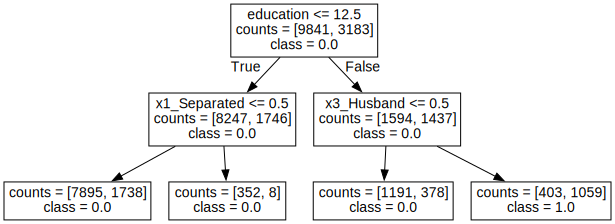

prediction [0.]


Tree 3


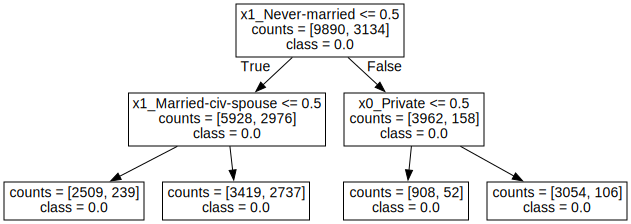

prediction [0.]


In [22]:
from utils import display_tree

for i, tree in enumerate(
    pipe_rf_demo.named_steps["randomforestclassifier"].estimators_
):
    print("\n\nTree", i + 1)
    display(display_tree(feature_names, tree, counts=True))
    print("prediction", tree.predict(preprocessor.transform(test_example)))

### Some important hyperparameters:

- `n_estimators`: number of decision trees (higher = more trees = more chance of memorizing train set and getting 100% train score, not necessarily degrading validation score)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (lower = more randomness = more diversity across estimators = less chance of overfitting)


### Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 

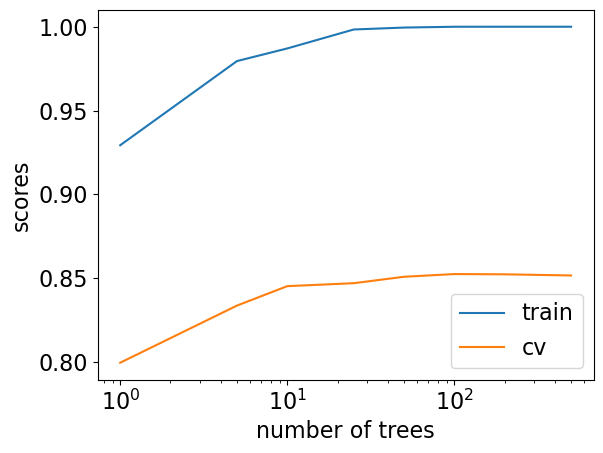

In [23]:
from plotting_functions import make_num_tree_plot
make_num_tree_plot(
    preprocessor, X_train, y_train, X_test, y_test, [1, 5, 10, 25, 50, 100, 200, 500]
)

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by increasing training score and not decreasing validation score much.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.



**More trees are better! We pick less trees for speed.**

<br><br><br><br><br><br><br><br>

### Strengths and weaknesses of RandomForest

- Usually one of the best performing off-the-shelf classifiers without heavy tuning of hyperparameters
- Don't require scaling of data 
- Less likely to overfit 
- Slower than decision trees because we are fitting multiple trees but can easily **parallelize training** because all trees are independent of each other (that said, sklearn implementation is kind of slow)
- In general, able to capture a much broader picture of the data compared to a single decision tree. 

### Weaknesses

- Require more memory 
- **Hard to interpret**
- Tend not to perform well on high dimensional sparse data such as text data



<br><br><br>
**Warning**: It's a **Random**Forest, expect randomness! Make sure to set the `random_state` for reproducibility. Changing the `random_state` can have a big impact on the model and the results due to the random nature of these models. Having more trees can get you a more robust estimate. 


<img src=https://upload.wikimedia.org/wikipedia/en/4/4d/Leo_Breiman.jpg>

Leo Breiman, 1928 – 2005
- University of California, Berkeley
- classification and regression trees and ensembles of trees fit to bootstrap samples
- **Bootstrap aggregation** was given the name **Bagging** by Breiman
- **Random Forest**: [The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)

<br><br>

## ❓❓ Questions for you

### (iClicker) Exercise 11.1 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

- (A) Every tree in a random forest uses a different bootstrap sample of the training set.
- (B) To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features.
- (C) A reasonable implementation of `predict_proba` for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities.
- (D) Decreasing the hyperparameter max_features (the number of features to consider for a split) doesn’t allow each estimator (tree) to fit too closely to the data.
- (E) A random forest with only one tree is likely to get a **higher** training error than a decision tree of the same depth.

Correct Answers: 
- A
- C 
- D
- E

B is incorrect, because we subsample features at each split

Regarding C: If we have a lot of estimators, we can use their votes as a means of inferring probability. For example, imagine you have 1000 estimators, and 850 of them classify a sample as positive. Then, you might be able to say "my ensemble model has confidence of 0.85 for the given sample being a positive sample"

--------------

**[Bonus]**



[`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
adds more randomness choosing random splits for each feeature.

Difference between RandomForest and ExtraTrees:
- RandomForest chooses the optimum split while ExtraTrees chooses it randomly. 
- However, once the split points are selected, the two algorithms choose the best one between all the subset of features. So, Extra Trees adds randomization during splitting but still does optimization during feature selection.


[End of bonus]

---------------

<br><br><br><br>

## Gradient boosted trees 

Another popular and effective class of tree-based models is gradient boosted trees. 

- No randomization.
- The key idea is combining many simple models called weak learners to create a strong learner. 
- They combine multiple shallow (depth 1 to 5) decision trees  
- They build trees in a **serial manner** (NOT independent in parallel), where each tree tries to **correct the mistakes** of the previous one. 

### Important hyperparameters

- `n_estimators`
    - control the number of trees to build
- `learning_rate`
    - controls how strongly each tree tries to correct the mistakes of the previous trees
    - **lower** learning rate 
      - **slows down** the learning in the gradient boosting model by making less corrections for each tree added to the model. 
      - This in turn results in **more trees** that must be added to the model.

We'll not go into the details. We'll look at brief examples of using the following three gradient boosted tree models. 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*PJXOO3x2HC_XfnxvjN-dEg.png">

Source of the above image, and a good overview blog post on the 3 models: [check here](https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924#:~:text=In%20CatBoost%2C%20symmetric%20trees%2C%20or,the%20same%20depth%20can%20differ.)

### [XGBoost](https://xgboost.ai/about) 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge xgboost`
- Supports missing values
- GPU training, networked parallel training
- Supports sparse data
- Typically better scores than random forests    

### [LightGBM](https://lightgbm.readthedocs.io/)

- Its name (Light) implies a lighter model and more speed, and yes, it is **faster**
- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge lightgbm`
- Small model size
- Faster 
- Typically better scores than random forests

### [CatBoost](https://catboost.ai/)

> CatBoost is an open-source machine learning(gradient boosting) algorithm, with its name coined from “Category” and “Boosting.” It was developed by Yandex (Russian Google ) in 2017. According to Yandex, CatBoost has been applied to a wide range of areas such as recommendation systems, search ranking, self-driving cars, forecasting, and virtual assistants. It is the successor of MatrixNet that was widely used within Yandex products.  
[https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm]

- Name comes from its focus on **Categorical** features
- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge catboost`
- CatBoost supports distributed training across GPUs
- Usually better scores but slower compared to `XGBoost` and `LightGBM`     

In [ ]:
!conda install -c conda-forge xgboost -y
!conda install -c conda-forge lightgbm -y
!conda install -c conda-forge catboost -y

In [24]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)
classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    # "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [25]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [26]:
results = {}

In [28]:
adult_df_large = pd.read_csv("../data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.6, random_state=42)

# Replace question marks in the dataset with NaN values
train_df_nan = train_df.replace("?", np.NaN).dropna()
test_df_nan = test_df.replace("?", np.NaN).dropna()
train_df_nan.head()

X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

In [29]:
y_train_xgboost = y_train.copy()
y_train_xgboost[y_train_xgboost == '<=50K'] = 0
y_train_xgboost[y_train_xgboost == '>50K'] = 1

In [30]:
y_train_xgboost

414      1
7887     0
23438    0
20514    0
31064    0
        ..
29802    0
5390     1
860      1
15795    1
23654    0
Name: income, Length: 12059, dtype: object

In [31]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [32]:
for (name, model) in classifiers.items():
    print(name)
    if name == 'XGBoost':
        results[name] = mean_std_cross_val_scores(
            model, X_train, y_train_xgboost, return_train_score=True, scoring=scoring_metric
        )
    else:
        results[name] = mean_std_cross_val_scores(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )

logistic regression
decision tree
random forest
LightGBM
CatBoost


In [33]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.002),0.004 (+/- 0.002),0.629 (+/- 0.008),0.630 (+/- 0.003)
logistic regression,0.339 (+/- 0.029),0.012 (+/- 0.001),0.845 (+/- 0.005),0.847 (+/- 0.001)
decision tree,0.093 (+/- 0.002),0.015 (+/- 0.002),0.805 (+/- 0.007),1.000 (+/- 0.000)
random forest,0.877 (+/- 0.012),0.056 (+/- 0.004),0.847 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.099 (+/- 0.008),0.017 (+/- 0.001),0.864 (+/- 0.003),0.906 (+/- 0.001)
CatBoost,2.357 (+/- 0.095),0.056 (+/- 0.002),0.866 (+/- 0.003),0.904 (+/- 0.001)


**Some observations**
- Keep in mind that all these results are with default hyperparameters
- Ideally we would carry out hyperparameter optimization for all of them and then compare the results. 
- We are using a particular scoring metric (accuracy in this case)
- We are scaling numeric features but it shouldn't matter for these tree-based models. 
- Look at the std. Doesn't look very high. 
    - The scores look more or less stable. 

- Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest followed by random forests.  
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost but it is about 48x slower than LightGBM!
    - XGBoost and LightGBM are faster and more accurate than random forest!    
- Scores times  
    - Prediction times are much smaller in all cases. 

### What classifier should I use?

**Simple answer**
- Whichever gets the highest CV score making sure that you're not overusing the validation set.

<br><br><br><br>

## Averaging 

Earlier we looked at a bunch of classifiers:

In [35]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'LightGBM', 'CatBoost'])

What if we use all these models and let them vote during prediction time? 

In [36]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), 
    voting="soft"
)  # need the list() here for cross_val to work!

In [37]:
from sklearn import set_config

set_config(display="diagram")  # global setting

In [38]:
averaging_model

VotingClassifier(estimators=[('logistic regression',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                Pipeline(steps=[('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['age',
                                                                                 'fnlwgt',
                                                                                 'capital.gain',
                                                                                 'capital.loss',
                                                                                 'hours.per.week']),
                                                                               ('pipeline-2',
                                                                                Pipeline(steps=[('ordinalencoder',
                                                                                                 OrdinalEncoder(categories=[['Preschool',
                                                                                                                             '1st-4th'...
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(fill_value='missing',
                                                                                                               strategy='constant')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['workclass',
                                                                                 'marital.status',
                                                                                 'occupation',
                                                                                 'relationship',
                                                                                 'native.country']),
                                                                               ('drop',
                                                                                'drop',
                                                                                ['race',
                                                                                 'education.num'])])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x188a35000>)]))],
                 voting='soft')

This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifier pipelines.

Main parameter: `voting`
- `voting='hard'` 
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.

- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [39]:
averaging_model.fit(X_train, y_train);

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models.    

```{note}
It seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.
```

Let's look at particular test examples where `income` is ">50k" (y=1):

In [43]:
test_g50k = (
    test_df.query("income == '>50K'").sample(4, random_state=2).drop(columns=["income"])
)
test_l50k = (
    test_df.query("income == '<=50K'")
    .sample(4, random_state=2)
    .drop(columns=["income"])
)

In [44]:
averaging_model.classes_

array(['<=50K', '>50K'], dtype=object)

In [45]:
data = {"Voting classifier": averaging_model.predict(test_l50k)}
pd.DataFrame(data)

,Voting classifier
0,<=50K
1,>50K
2,<=50K
3,<=50K


For hard voting, these are the votes:

In [46]:
r1 = {
    name: classifier.predict(test_l50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
data.update(r1)
pd.DataFrame(data)

,Voting classifier,logistic regression,decision tree,random forest,LightGBM,CatBoost
0,<=50K,0,0,0,0,0
1,>50K,1,1,1,1,1
2,<=50K,0,0,0,0,0
3,<=50K,0,0,0,0,0


For soft voting, these are the scores:

In [47]:
r1 = {
    name: classifier.predict_proba(test_l50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
r1

{'logistic regression': array([[0.99805199, 0.00194801],
        [0.46628377, 0.53371623],
        [0.97553226, 0.02446774],
        [0.95645801, 0.04354199]]),
 'decision tree': array([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[1.  , 0.  ],
        [0.34, 0.66],
        [0.94, 0.06],
        [0.83, 0.17]]),
 'LightGBM': array([[9.99632919e-01, 3.67081123e-04],
        [4.45846309e-01, 5.54153691e-01],
        [9.46901204e-01, 5.30987958e-02],
        [9.24003719e-01, 7.59962813e-02]]),
 'CatBoost': array([[0.99893007, 0.00106993],
        [0.49754102, 0.50245898],
        [0.95482136, 0.04517864],
        [0.89076701, 0.10923299]])}

Let's see how well this model performs.

In [48]:
results["Voting"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

In [49]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.002),0.004 (+/- 0.002),0.629 (+/- 0.008),0.630 (+/- 0.003)
logistic regression,0.339 (+/- 0.029),0.012 (+/- 0.001),0.845 (+/- 0.005),0.847 (+/- 0.001)
decision tree,0.093 (+/- 0.002),0.015 (+/- 0.002),0.805 (+/- 0.007),1.000 (+/- 0.000)
random forest,0.877 (+/- 0.012),0.056 (+/- 0.004),0.847 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.099 (+/- 0.008),0.017 (+/- 0.001),0.864 (+/- 0.003),0.906 (+/- 0.001)
CatBoost,2.357 (+/- 0.095),0.056 (+/- 0.002),0.866 (+/- 0.003),0.904 (+/- 0.001)
Voting,3.737 (+/- 0.067),0.136 (+/- 0.006),0.857 (+/- 0.005),NaN


It appears that here we didn't do much better than our best classifier :(. 

Let's try removing decision tree classifier. 

In [53]:
classifiers_ndt = classifiers.copy()
del classifiers_ndt["decision tree"]
averaging_model_ndt = VotingClassifier(
    list(classifiers_ndt.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_ndt"] = mean_std_cross_val_scores(
    averaging_model_ndt,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)

In [54]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.002),0.004 (+/- 0.002),0.629 (+/- 0.008),0.630 (+/- 0.003)
logistic regression,0.339 (+/- 0.029),0.012 (+/- 0.001),0.845 (+/- 0.005),0.847 (+/- 0.001)
decision tree,0.093 (+/- 0.002),0.015 (+/- 0.002),0.805 (+/- 0.007),1.000 (+/- 0.000)
random forest,0.877 (+/- 0.012),0.056 (+/- 0.004),0.847 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.099 (+/- 0.008),0.017 (+/- 0.001),0.864 (+/- 0.003),0.906 (+/- 0.001)
CatBoost,2.357 (+/- 0.095),0.056 (+/- 0.002),0.866 (+/- 0.003),0.904 (+/- 0.001)
Voting,3.737 (+/- 0.067),0.136 (+/- 0.006),0.857 (+/- 0.005),NaN
Voting_ndt,3.525 (+/- 0.080),0.125 (+/- 0.004),0.864 (+/- 0.006),0.928 (+/- 0.001)


Still the results are not better than the best performing model. 

- It didn't happen here but how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??


Here's how this can work:

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


**In short, as long as the different models make different mistakes, this can work.**

Why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

### What kind of estimators can we combine? 

- You can combine 
    - completely different estimators, or similar estimators.
    - estimators trained on different samples.
    - estimators with different hyperparameter values.

<br><br><br><br>

## Stacking (Meta-learning model)


- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use their outputs as _inputs to another model_.
- In sklearn, the `StackingClassifier` uses logistic regression for classification as the `final_estimator`
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [55]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; so we'll remove CatBoost. 

In [57]:
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [58]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

In [70]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)

 > Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

Here is the input features (X) to the meta-model:

In [60]:
valid_sample = train_df.sample(4, random_state=2).drop(columns=["income"])

In [61]:
r3 = {
    name: pipe.predict_proba(valid_sample)
    for (name, pipe) in stacking_model.named_estimators_.items()
}
r3

{'logistic regression': array([[0.76042593, 0.23957407],
        [0.99486327, 0.00513673],
        [0.8344347 , 0.1655653 ],
        [0.95955776, 0.04044224]]),
 'decision tree': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[0.84, 0.16],
        [1.  , 0.  ],
        [0.95, 0.05],
        [1.  , 0.  ]]),
 'LightGBM': array([[6.32578669e-01, 3.67421331e-01],
        [9.99269984e-01, 7.30015828e-04],
        [8.08024824e-01, 1.91975176e-01],
        [9.70264982e-01, 2.97350184e-02]])}

- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [62]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_[0],
    index=classifiers_nocat.keys(),
    columns=["Coefficient"],
)

,Coefficient
logistic regression,1.719575
decision tree,-0.006668
random forest,0.373751
LightGBM,4.384420


In [64]:
stacking_model.final_estimator_.intercept_

array([-3.24473463])

- It seems that the LightGBM is being trusted the most. 

In [65]:
stacking_model.predict(test_g50k)

array(['<=50K', '>50K', '<=50K', '<=50K'], dtype=object)

In [71]:
test_g50k

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
5861,42,Local-gov,445382,Bachelors,13,Separated,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States
4373,45,Self-emp-not-inc,201080,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
17218,42,Private,99679,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States
3295,43,Private,313022,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,4386,0,40,United-States


In [66]:
stacking_model.predict_proba(test_g50k)

array([[0.81276671, 0.18723329],
       [0.36969417, 0.63030583],
       [0.76472883, 0.23527117],
       [0.65196505, 0.34803495]])

(This is the `predict_proba` from logistic regression)

Let's see how well this model performs.

In [67]:
results["Stacking_nocat"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [68]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.005 (+/- 0.002),0.004 (+/- 0.002),0.629 (+/- 0.008),0.630 (+/- 0.003)
logistic regression,0.339 (+/- 0.029),0.012 (+/- 0.001),0.845 (+/- 0.005),0.847 (+/- 0.001)
decision tree,0.093 (+/- 0.002),0.015 (+/- 0.002),0.805 (+/- 0.007),1.000 (+/- 0.000)
random forest,0.877 (+/- 0.012),0.056 (+/- 0.004),0.847 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.099 (+/- 0.008),0.017 (+/- 0.001),0.864 (+/- 0.003),0.906 (+/- 0.001)
CatBoost,2.357 (+/- 0.095),0.056 (+/- 0.002),0.866 (+/- 0.003),0.904 (+/- 0.001)
Voting,3.737 (+/- 0.067),0.136 (+/- 0.006),0.857 (+/- 0.005),NaN
Voting_ndt,3.525 (+/- 0.080),0.125 (+/- 0.004),0.864 (+/- 0.006),0.928 (+/- 0.001)
Stacking_nocat,7.458 (+/- 0.539),0.088 (+/- 0.010),0.866 (+/- 0.006),0.900 (+/- 0.003)


- The situation here is a bit mind-boggling.
- On each fold of cross-validation it is doing cross-validation.
- This is really loops within loops within loops within loops...

- We can also try a different final estimator:
- Let's `DecisionTreeClassifier` as a final estimator. 

In [72]:
stacking_model_tree = StackingClassifier(
    list(classifiers_nocat.items()), final_estimator=DecisionTreeClassifier(max_depth=3)
)

The results are not very good. But we can look at the tree:

In [73]:
stacking_model_tree.fit(X_train, y_train);

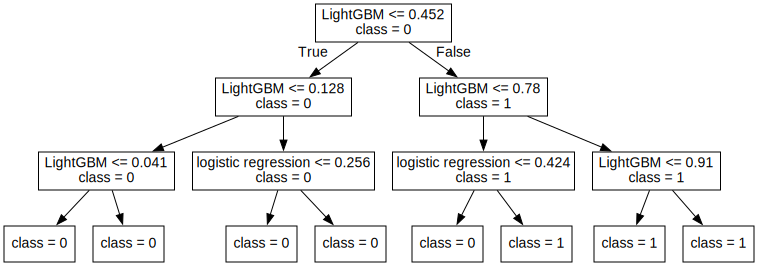

In [74]:
display_tree(list(classifiers_nocat.keys()), stacking_model_tree.final_estimator_)

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a better score.
- What is an disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - Slower, more code maintenance issues.

------------
<br><br><br><br><br><br>
## Final thoughts on Ensemble models

<img src="https://vitalflux.com/wp-content/uploads/2022/11/boosting-vs-bagging-differences-examples-640x332.png">



- **Bagging**: Often considers homogeneous weak learners, learns them independently from each other in parallel and combines them following some kind of averaging process
  - Bagging reduces Variance (bagging technique tries to resolve the issue of overfitting training data)
- **Boosting**: Often considers homogeneous weak learners, learns them **sequentially** in a very adaptative way (a base model depends on the previous ones) and combines them
  - Boosting reduces Bias
- **Stacking**: Often considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model (final estimator) to output a prediction based on the different weak models predictions


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*e-na5r7mF8lVAfPK.png">
-------------

<br><br><br><br><br><br>

### Question 11.3

Is this bagging or boosting?

Answer: Boosting

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/0*KcQZgCA34Cggnrso.png">

## Question 11.4

Is this bagging or boosting?

Answer: Bagging


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*alEu0ArH61Hfz2k2wQHNnA.png">

## Summary 

- You have a number of models in your toolbox now.  
- Ensembles are usually pretty effective.
  - Tree-based classifiers are particularly popular and effective on a wide range of problems. 
  - But they trade off code complexity and speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting.
  - As a bonus, you get to see the coefficients for each base classifier.
- Most of the above approaches have regression models as well as classification models.

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.